In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/energydata_complete.csv")

In [3]:
ts = df["Appliances"]

In [4]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [5]:
dates = pd.to_datetime(df.date)

In [6]:
series = np.asarray(ts.values)

In [7]:
time = np.arange(series.shape[0])

In [8]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

## Forecasting with Linear Regression

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
dataset = dataset.window(5,shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 20000) #IID gd works best #buffersize must be greater or equal to the number of examples
dataset = dataset.batch(32).prefetch(1) # you probably will want bigger batchs like 32 / 64
for x, y in dataset:
    print(x.numpy(), y.numpy())

[[ 50  50  50  50]
 [ 70  70  50  50]
 [ 60  50  50  50]
 [ 50  40  50  50]
 [ 70  60  70  60]
 [260 230 470 400]
 [ 30  40  30  70]
 [ 50  60  60  70]
 [ 50  50  40  70]
 [ 70  70  40  40]
 [100  90 130 120]
 [ 50  40  40  40]
 [ 90  70  70  50]
 [ 50  40  40  40]
 [ 70 200 280 180]
 [ 40  50  50  50]
 [ 50  70 100  60]
 [ 50  50  50  50]
 [ 60  50  60  60]
 [220  70  60  50]
 [ 60  50  50  60]
 [ 70 390 640 510]
 [740 590 380 280]
 [ 60  80  40 290]
 [ 60  50  20  20]
 [ 90 190 370 280]
 [ 20  40  40  40]
 [110 100  90  90]
 [110 110 110 110]
 [ 70  40  40  40]
 [ 50  40  60  40]
 [110 100 110 110]] [[ 50]
 [ 50]
 [ 60]
 [ 50]
 [ 70]
 [290]
 [ 60]
 [ 70]
 [180]
 [ 50]
 [140]
 [ 40]
 [ 50]
 [ 30]
 [180]
 [ 50]
 [ 60]
 [ 40]
 [ 50]
 [ 60]
 [ 50]
 [300]
 [240]
 [130]
 [ 30]
 [130]
 [ 40]
 [ 90]
 [110]
 [ 30]
 [ 60]
 [ 90]]
[[360 680 520 430]
 [ 80  80 400 400]
 [ 60  60  60  50]
 [ 50  80  40  50]
 [100 100  70  80]
 [ 50  60  60  50]
 [ 60  50  50  70]
 [130 130 150 120]
 [ 60  50  50 

[[ 90  90  90  80]
 [ 80  60  80  70]
 [230 100  90  90]
 [130 110 120 100]
 [ 60  50  60  60]
 [ 90 190 420 230]
 [110 110 630 400]
 [ 40  40  50  50]
 [110 400 400 390]
 [ 50  90 100  60]
 [ 60  50  70  60]
 [ 40  50  50  50]
 [ 60  50  60  50]
 [ 40  60  40  50]
 [100  80  90 100]
 [ 60  50  70  50]
 [ 40  90  70 280]
 [ 70  60  60  60]
 [ 60  50  60  50]
 [ 60  60  60  70]
 [100  90  70  70]
 [300  70 360 170]
 [ 60  40  20  30]
 [ 40  30  40  30]
 [ 70  60  70  70]
 [ 50  50  60  40]
 [ 60  70  50  60]
 [ 50  50  60  90]
 [ 30  30  20  20]
 [ 40  40  40  50]
 [390 410 630 450]
 [ 40  40  40  40]] [[ 90]
 [ 70]
 [110]
 [110]
 [ 60]
 [650]
 [350]
 [ 50]
 [240]
 [ 40]
 [ 70]
 [ 60]
 [ 30]
 [ 40]
 [ 90]
 [ 60]
 [180]
 [ 50]
 [ 40]
 [ 60]
 [ 60]
 [330]
 [ 20]
 [ 50]
 [ 70]
 [ 50]
 [ 60]
 [ 70]
 [ 50]
 [ 50]
 [420]
 [ 40]]
[[ 40  20  50  50]
 [ 40  30  40  40]
 [ 50  50  40  50]
 [340 100  90 110]
 [ 50  50  50  50]
 [150  80  60  60]
 [100 100  90 100]
 [ 40  30  20  30]
 [ 50  30  40 

In [9]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 20000):
    dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size = shuffle_buffer) #IID gd works best #buffersize must be greater or equal to the number of examples
    dataset = dataset.batch(batch_size).prefetch(1) # you probably will want bigger batchs like 32 / 64
    return dataset

In [10]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss = keras.losses.mean_squared_error,
             optimizer = optimizer,
             metrics = ["mse"])
early_stopping = keras.callbacks.EarlyStopping(patience = 10)
model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping])

Epoch 1/500
493/493 [==============================] - 2s 5ms/step - loss: 121902.1824 - mse: 121922.8984 - val_loss: 95044.7914 - val_mse: 95357.5312
Epoch 2/500
493/493 [==============================] - 2s 4ms/step - loss: 113334.7055 - mse: 113266.9375 - val_loss: 87872.4018 - val_mse: 88027.1641
Epoch 3/500
493/493 [==============================] - 2s 4ms/step - loss: 105202.1297 - mse: 105260.7031 - val_loss: 81028.6294 - val_mse: 81267.2422
Epoch 4/500
493/493 [==============================] - 2s 4ms/step - loss: 97860.1031 - mse: 97893.5391 - val_loss: 75265.2882 - val_mse: 75056.5703
Epoch 5/500
493/493 [==============================] - 2s 4ms/step - loss: 91064.0752 - mse: 91091.8125 - val_loss: 69141.1597 - val_mse: 69333.6094
Epoch 6/500
493/493 [==============================] - 2s 4ms/step - loss: 84791.6113 - mse: 84821.5391 - val_loss: 64063.4047 - val_mse: 64046.7461
Epoch 7/500
493/493 [==============================] - 2s 4ms/step - loss: 79126.7490 - mse: 79077.2

493/493 [==============================] - 2s 4ms/step - loss: 18974.2871 - mse: 18987.2480 - val_loss: 12820.9003 - val_mse: 12808.8340
Epoch 56/500
493/493 [==============================] - 2s 4ms/step - loss: 18631.3776 - mse: 18644.2500 - val_loss: 12550.6961 - val_mse: 12580.5557
Epoch 57/500
493/493 [==============================] - 2s 4ms/step - loss: 18299.5404 - mse: 18310.4102 - val_loss: 12311.7321 - val_mse: 12357.8613
Epoch 58/500
493/493 [==============================] - 2s 4ms/step - loss: 17977.8758 - mse: 17985.1484 - val_loss: 12181.9259 - val_mse: 12140.9424
Epoch 59/500
493/493 [==============================] - 2s 4ms/step - loss: 17659.7875 - mse: 17668.7676 - val_loss: 11893.9659 - val_mse: 11929.8086
Epoch 60/500
493/493 [==============================] - 2s 4ms/step - loss: 17345.2710 - mse: 17358.8672 - val_loss: 11675.0627 - val_mse: 11723.7832
Epoch 61/500
493/493 [==============================] - 2s 4ms/step - loss: 17046.6645 - mse: 17055.7207 - val_lo

493/493 [==============================] - 2s 4ms/step - loss: 8828.7588 - mse: 8819.8574 - val_loss: 6076.9358 - val_mse: 6092.0249
Epoch 111/500
493/493 [==============================] - 2s 4ms/step - loss: 8729.0369 - mse: 8734.3242 - val_loss: 6041.0421 - val_mse: 6036.6226
Epoch 112/500
493/493 [==============================] - 2s 4ms/step - loss: 8643.4462 - mse: 8650.5527 - val_loss: 5956.9008 - val_mse: 5981.6343
Epoch 113/500
493/493 [==============================] - 2s 4ms/step - loss: 8569.8150 - mse: 8568.3887 - val_loss: 5917.6117 - val_mse: 5927.8579
Epoch 114/500
493/493 [==============================] - 2s 4ms/step - loss: 8482.9091 - mse: 8488.6650 - val_loss: 5854.7434 - val_mse: 5876.0771
Epoch 115/500
493/493 [==============================] - 2s 4ms/step - loss: 8411.5819 - mse: 8410.9580 - val_loss: 5837.3346 - val_mse: 5826.0664
Epoch 116/500
493/493 [==============================] - 2s 4ms/step - loss: 8354.1733 - mse: 8335.4854 - val_loss: 5880.2946 - val_

Epoch 166/500
493/493 [==============================] - 2s 4ms/step - loss: 6116.0054 - mse: 6117.7642 - val_loss: 4342.6925 - val_mse: 4361.8008
Epoch 167/500
493/493 [==============================] - 2s 4ms/step - loss: 6094.3177 - mse: 6094.3921 - val_loss: 4332.2596 - val_mse: 4347.6309
Epoch 168/500
493/493 [==============================] - 2s 4ms/step - loss: 6075.4041 - mse: 6071.6128 - val_loss: 4357.9423 - val_mse: 4333.8027
Epoch 169/500
493/493 [==============================] - 2s 4ms/step - loss: 6043.1399 - mse: 6049.1201 - val_loss: 4332.0650 - val_mse: 4319.7231
Epoch 170/500
493/493 [==============================] - 2s 4ms/step - loss: 6029.0484 - mse: 6027.1982 - val_loss: 4288.6070 - val_mse: 4306.5400
Epoch 171/500
493/493 [==============================] - 2s 4ms/step - loss: 6000.8241 - mse: 6005.7109 - val_loss: 4274.1960 - val_mse: 4293.4424
Epoch 172/500
493/493 [==============================] - 2s 4ms/step - loss: 5980.4294 - mse: 5984.6445 - val_loss: 42

Epoch 222/500
493/493 [==============================] - 2s 4ms/step - loss: 5324.0837 - mse: 5329.9473 - val_loss: 3877.8772 - val_mse: 3895.8796
Epoch 223/500
493/493 [==============================] - 2s 4ms/step - loss: 5315.7750 - mse: 5321.7729 - val_loss: 3922.9313 - val_mse: 3891.1860
Epoch 224/500
493/493 [==============================] - 2s 4ms/step - loss: 5317.7956 - mse: 5313.6982 - val_loss: 3869.1187 - val_mse: 3886.6707
Epoch 225/500
493/493 [==============================] - 2s 4ms/step - loss: 5313.0361 - mse: 5306.0015 - val_loss: 3865.6071 - val_mse: 3882.5640
Epoch 226/500
493/493 [==============================] - 2s 4ms/step - loss: 5292.5577 - mse: 5298.1523 - val_loss: 3891.0152 - val_mse: 3878.1038
Epoch 227/500
493/493 [==============================] - 2s 4ms/step - loss: 5284.7746 - mse: 5290.6196 - val_loss: 3914.3569 - val_mse: 3873.7158
Epoch 228/500
493/493 [==============================] - 2s 4ms/step - loss: 5278.6500 - mse: 5283.3745 - val_loss: 39

Epoch 278/500
493/493 [==============================] - 2s 4ms/step - loss: 5008.7318 - mse: 5013.2163 - val_loss: 3720.5248 - val_mse: 3727.1555
Epoch 279/500
493/493 [==============================] - 2s 4ms/step - loss: 5012.7210 - mse: 5009.6216 - val_loss: 3724.4616 - val_mse: 3725.1667
Epoch 280/500
493/493 [==============================] - 2s 4ms/step - loss: 5004.6308 - mse: 5005.5044 - val_loss: 3706.1222 - val_mse: 3723.7129
Epoch 281/500
493/493 [==============================] - 2s 4ms/step - loss: 4999.0472 - mse: 5001.6982 - val_loss: 3707.1911 - val_mse: 3721.5959
Epoch 282/500
493/493 [==============================] - 2s 4ms/step - loss: 4992.9821 - mse: 4997.9434 - val_loss: 3704.9766 - val_mse: 3719.7175
Epoch 283/500
493/493 [==============================] - 2s 4ms/step - loss: 4988.9448 - mse: 4994.1172 - val_loss: 3701.5591 - val_mse: 3717.8535
Epoch 284/500
493/493 [==============================] - 2s 4ms/step - loss: 4987.9418 - mse: 4990.4912 - val_loss: 37

Epoch 334/500
493/493 [==============================] - 2s 4ms/step - loss: 4857.8572 - mse: 4848.7627 - val_loss: 3647.8997 - val_mse: 3646.9431
Epoch 335/500
493/493 [==============================] - 2s 4ms/step - loss: 4842.7128 - mse: 4846.4780 - val_loss: 3641.8724 - val_mse: 3645.5989
Epoch 336/500
493/493 [==============================] - 2s 4ms/step - loss: 4844.7360 - mse: 4844.2729 - val_loss: 3628.8243 - val_mse: 3644.9368
Epoch 337/500
493/493 [==============================] - 2s 4ms/step - loss: 4841.5719 - mse: 4842.3828 - val_loss: 3681.1992 - val_mse: 3644.0042
Epoch 338/500
493/493 [==============================] - 2s 4ms/step - loss: 4835.4996 - mse: 4840.1357 - val_loss: 3638.8227 - val_mse: 3642.6987
Epoch 339/500
493/493 [==============================] - 2s 4ms/step - loss: 4832.5408 - mse: 4837.7949 - val_loss: 3624.8910 - val_mse: 3641.7300
Epoch 340/500
493/493 [==============================] - 2s 4ms/step - loss: 4832.5722 - mse: 4835.7231 - val_loss: 36

Epoch 390/500
493/493 [==============================] - 2s 4ms/step - loss: 4769.0676 - mse: 4749.7920 - val_loss: 3586.2484 - val_mse: 3601.5439
Epoch 391/500
493/493 [==============================] - 2s 4ms/step - loss: 4748.8517 - mse: 4748.4204 - val_loss: 3631.0490 - val_mse: 3600.9065
Epoch 392/500
493/493 [==============================] - 2s 4ms/step - loss: 4742.1100 - mse: 4747.1187 - val_loss: 3598.9202 - val_mse: 3600.2126
Epoch 393/500
493/493 [==============================] - 2s 4ms/step - loss: 4755.9206 - mse: 4745.4434 - val_loss: 3597.5500 - val_mse: 3600.0688
Epoch 394/500
493/493 [==============================] - 2s 4ms/step - loss: 4744.4518 - mse: 4744.3604 - val_loss: 3583.2843 - val_mse: 3599.0813
Epoch 395/500
493/493 [==============================] - 2s 4ms/step - loss: 4741.5174 - mse: 4743.0449 - val_loss: 3605.1758 - val_mse: 3598.3052
Epoch 396/500
493/493 [==============================] - 2s 4ms/step - loss: 4738.3083 - mse: 4741.6841 - val_loss: 35

Epoch 446/500
493/493 [==============================] - 2s 4ms/step - loss: 4687.3385 - mse: 4685.9712 - val_loss: 3557.7938 - val_mse: 3573.4041
Epoch 447/500
493/493 [==============================] - 2s 4ms/step - loss: 4680.5728 - mse: 4685.0796 - val_loss: 3571.6532 - val_mse: 3573.0679
Epoch 448/500
493/493 [==============================] - 2s 4ms/step - loss: 4679.3739 - mse: 4684.1914 - val_loss: 3560.4834 - val_mse: 3572.6477
Epoch 449/500
493/493 [==============================] - 2s 4ms/step - loss: 4677.9438 - mse: 4683.0757 - val_loss: 3582.6141 - val_mse: 3572.7256
Epoch 450/500
493/493 [==============================] - 2s 4ms/step - loss: 4679.9814 - mse: 4682.3003 - val_loss: 3570.1086 - val_mse: 3571.9883
Epoch 451/500
493/493 [==============================] - 2s 4ms/step - loss: 4679.6708 - mse: 4681.4346 - val_loss: 3556.1396 - val_mse: 3571.7151
Epoch 452/500
493/493 [==============================] - 2s 4ms/step - loss: 4685.7921 - mse: 4680.5122 - val_loss: 35

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [14]:
lin_forecast = model_forecast(
    model,
    series[split_time - window_size: -1],
    window_size)
lin_forecast = lin_forecast[:,0]

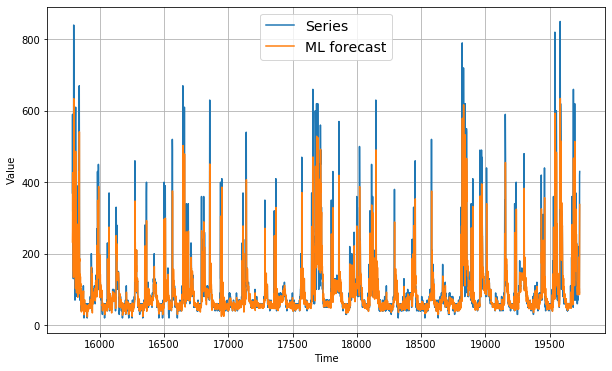

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lin_forecast, label="ML forecast")

In [16]:
tf.keras.metrics.mse(x_valid, lin_forecast).numpy()

3711.4832

In [17]:
tf.keras.metrics.mae(x_valid, lin_forecast).numpy()

27.055275

* we surpassed the naive approach, this is now our best performance yet

### Using two relu dense layers

In [11]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.Adam()

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 1)

model.compile(loss = keras.losses.mean_squared_error,
             optimizer = optimizer,
             metrics = ["mse"])
#early_stopping = keras.callbacks.EarlyStopping(patience = 10)
history = model.fit(train_set, epochs = 100,
         validation_data = valid_set,
         callbacks = [lr_schedule])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
Epoch 1/100
493/493 [==============================] - 3s 5ms/step - loss: 25723.5166 - mse: 25734.4941 - val_loss: 20547.4373 - val_mse: 20602.0137

Epoch 00002: LearningRateScheduler reducing learning rate to 1.1220184543019634e-08.
Epoch 2/100
493/493 [==============================] - 2s 4ms/step - loss: 25707.9437 - mse: 25731.4961 - val_loss: 20614.3199 - val_mse: 20599.1855

Epoch 00003: LearningRateScheduler reducing learning rate to 1.2589254117941673e-08.
Epoch 3/100
493/493 [==============================] - 2s 4ms/step - loss: 25740.6332 - mse: 25728.2168 - val_loss: 20546.0679 - val_mse: 20596.0840

Epoch 00004: LearningRateScheduler reducing learning rate to 1.4125375446227544e-08.
Epoch 4/100
493/493 [==============================] - 2s 4ms/step - loss: 25708.4280 - mse: 25724.3594 - val_loss: 20658.4975 - val_mse: 20592.0000

Epoch 00005: LearningRateScheduler reducing learning rate to 1.5848931924611


Epoch 00036: LearningRateScheduler reducing learning rate to 5.623413251903491e-07.
Epoch 36/100
493/493 [==============================] - 2s 4ms/step - loss: 23325.9261 - mse: 23309.2695 - val_loss: 18278.3157 - val_mse: 18320.7910

Epoch 00037: LearningRateScheduler reducing learning rate to 6.309573444801933e-07.
Epoch 37/100
493/493 [==============================] - 2s 4ms/step - loss: 23046.0823 - mse: 23032.3477 - val_loss: 18032.5631 - val_mse: 18061.8242

Epoch 00038: LearningRateScheduler reducing learning rate to 7.079457843841381e-07.
Epoch 38/100
493/493 [==============================] - 2s 4ms/step - loss: 22708.0468 - mse: 22727.9453 - val_loss: 17725.2215 - val_mse: 17775.5215

Epoch 00039: LearningRateScheduler reducing learning rate to 7.943282347242815e-07.
Epoch 39/100
493/493 [==============================] - 2s 5ms/step - loss: 22405.6965 - mse: 22395.1289 - val_loss: 17440.0338 - val_mse: 17463.4492

Epoch 00040: LearningRateScheduler reducing learning rate t

493/493 [==============================] - 2s 4ms/step - loss: 8499.9649 - mse: 8486.2852 - val_loss: 5883.3812 - val_mse: 5907.7324

Epoch 00072: LearningRateScheduler reducing learning rate to 3.5481338923357534e-05.
Epoch 72/100
493/493 [==============================] - 2s 5ms/step - loss: 8087.3523 - mse: 8086.9033 - val_loss: 5630.6662 - val_mse: 5655.1216

Epoch 00073: LearningRateScheduler reducing learning rate to 3.9810717055349735e-05.
Epoch 73/100
493/493 [==============================] - 2s 5ms/step - loss: 7693.6626 - mse: 7691.6846 - val_loss: 5425.0133 - val_mse: 5417.3511

Epoch 00074: LearningRateScheduler reducing learning rate to 4.466835921509631e-05.
Epoch 74/100
493/493 [==============================] - 2s 4ms/step - loss: 7354.3901 - mse: 7319.0371 - val_loss: 5200.5593 - val_mse: 5215.1475

Epoch 00075: LearningRateScheduler reducing learning rate to 5.011872336272725e-05.
Epoch 75/100
493/493 [==============================] - 2s 4ms/step - loss: 6979.5241 -

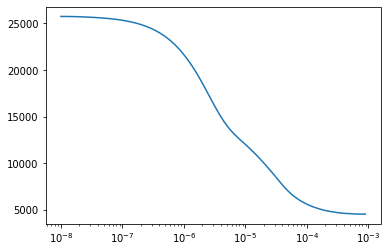

In [12]:
plt.semilogx(history.history["lr"], history.history["mse"])

In [13]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss = keras.losses.mean_squared_error,
             optimizer = optimizer,
             metrics = ["mse"])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)
history = model.fit(train_set, epochs = 100,
         validation_data = valid_set,
         callbacks = [early_stopping])

Epoch 1/100
493/493 [==============================] - 3s 6ms/step - loss: 8134.7886 - mse: 8142.8467 - val_loss: 4125.1385 - val_mse: 4142.1602
Epoch 2/100
493/493 [==============================] - 2s 5ms/step - loss: 5083.4836 - mse: 5083.7300 - val_loss: 3655.9992 - val_mse: 3672.1958
Epoch 3/100
493/493 [==============================] - 2s 4ms/step - loss: 4742.0122 - mse: 4739.0645 - val_loss: 3650.1006 - val_mse: 3661.2559
Epoch 4/100
493/493 [==============================] - 2s 4ms/step - loss: 4666.5005 - mse: 4669.9600 - val_loss: 3528.3849 - val_mse: 3533.8372
Epoch 5/100
493/493 [==============================] - 3s 5ms/step - loss: 4604.2533 - mse: 4599.8521 - val_loss: 3499.7652 - val_mse: 3515.9202
Epoch 6/100
493/493 [==============================] - 2s 5ms/step - loss: 4596.2635 - mse: 4595.1968 - val_loss: 3513.6477 - val_mse: 3520.1160
Epoch 7/100
493/493 [==============================] - 3s 5ms/step - loss: 4580.4877 - mse: 4571.5806 - val_loss: 3473.6588 - val_

In [16]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size: -1],
    window_size)
dense_forecast = dense_forecast[:,0]

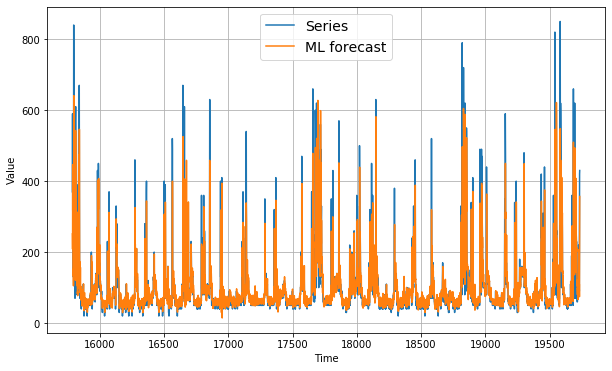

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, dense_forecast, label="ML forecast")

In [18]:
tf.keras.metrics.mse(x_valid, dense_forecast).numpy()

3577.0486

In [19]:
tf.keras.metrics.mae(x_valid, dense_forecast).numpy()

27.713793

* Slightly better in mse, which is our benchmark for the problem

## Using SGD

In [20]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model2 = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum = 0.9)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 1)

model2.compile(loss = keras.losses.mean_squared_error,
             optimizer = optimizer,
             metrics = ["mse"])
#early_stopping = keras.callbacks.EarlyStopping(patience = 10)
history2 = model2.fit(train_set, epochs = 100,
         validation_data = valid_set,
         callbacks = [lr_schedule])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
Epoch 1/100
493/493 [==============================] - 3s 6ms/step - loss: 12505.4677 - mse: 12518.7822 - val_loss: 6199.5201 - val_mse: 6207.6831

Epoch 00002: LearningRateScheduler reducing learning rate to 1.1220184543019634e-08.
Epoch 2/100
493/493 [==============================] - 2s 5ms/step - loss: 7623.3699 - mse: 7631.4771 - val_loss: 5384.4752 - val_mse: 5375.7480

Epoch 00003: LearningRateScheduler reducing learning rate to 1.2589254117941673e-08.
Epoch 3/100
493/493 [==============================] - 2s 5ms/step - loss: 6600.2599 - mse: 6600.5630 - val_loss: 4922.9427 - val_mse: 4845.3335

Epoch 00004: LearningRateScheduler reducing learning rate to 1.4125375446227544e-08.
Epoch 4/100
493/493 [==============================] - 2s 5ms/step - loss: 6011.5176 - mse: 6013.6865 - val_loss: 4493.6389 - val_mse: 4510.4761

Epoch 00005: LearningRateScheduler reducing learning rate to 1.5848931924611136e-08.
Epoch

493/493 [==============================] - 2s 4ms/step - loss: 4920.5863 - mse: 4914.5161 - val_loss: 3624.9263 - val_mse: 3641.2432

Epoch 00037: LearningRateScheduler reducing learning rate to 6.309573444801933e-07.
Epoch 37/100
493/493 [==============================] - 2s 4ms/step - loss: 5025.6990 - mse: 5022.0469 - val_loss: 4594.2722 - val_mse: 4614.2480

Epoch 00038: LearningRateScheduler reducing learning rate to 7.079457843841381e-07.
Epoch 38/100
493/493 [==============================] - 2s 4ms/step - loss: 5079.2275 - mse: 5082.6328 - val_loss: 3667.9475 - val_mse: 3679.9980

Epoch 00039: LearningRateScheduler reducing learning rate to 7.943282347242815e-07.
Epoch 39/100
493/493 [==============================] - 2s 4ms/step - loss: 4944.7179 - mse: 4950.0054 - val_loss: 3695.0084 - val_mse: 3701.5295

Epoch 00040: LearningRateScheduler reducing learning rate to 8.912509381337455e-07.
Epoch 40/100
493/493 [==============================] - 2s 4ms/step - loss: 5748.1079 - m

493/493 [==============================] - 2s 4ms/step - loss: 11087.0371 - mse: 11087.3535 - val_loss: 7793.4908 - val_mse: 7702.5796

Epoch 00072: LearningRateScheduler reducing learning rate to 3.5481338923357534e-05.
Epoch 72/100
493/493 [==============================] - 2s 4ms/step - loss: 11081.3129 - mse: 11082.8994 - val_loss: 7842.2205 - val_mse: 7805.2656

Epoch 00073: LearningRateScheduler reducing learning rate to 3.9810717055349735e-05.
Epoch 73/100
493/493 [==============================] - 2s 4ms/step - loss: 11080.7966 - mse: 11090.9170 - val_loss: 7706.2609 - val_mse: 7709.3760

Epoch 00074: LearningRateScheduler reducing learning rate to 4.466835921509631e-05.
Epoch 74/100
493/493 [==============================] - 2s 4ms/step - loss: 11140.4900 - mse: 11101.1631 - val_loss: 7675.7938 - val_mse: 7704.9043

Epoch 00075: LearningRateScheduler reducing learning rate to 5.011872336272725e-05.
Epoch 75/100
493/493 [==============================] - 2s 4ms/step - loss: 110

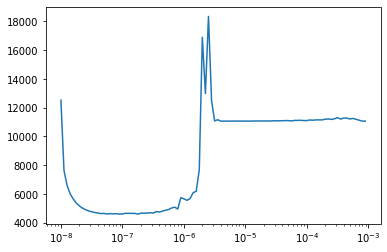

In [21]:
plt.semilogx(history2.history["lr"], history2.history["mse"])

* Ideal learning rate near $10^{-7}$

In [27]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model2 = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum = 0.9)

model2.compile(loss = keras.losses.mean_squared_error,
             optimizer = optimizer,
             metrics = ["mse"])
early_stopping = keras.callbacks.EarlyStopping(patience = 10)
history2 = model2.fit(train_set, epochs = 100,
         validation_data = valid_set,
         callbacks = [early_stopping])

Epoch 1/100
493/493 [==============================] - 3s 6ms/step - loss: 6851.6550 - mse: 6859.2803 - val_loss: 4031.2885 - val_mse: 4047.4841
Epoch 2/100
493/493 [==============================] - 2s 4ms/step - loss: 4957.0127 - mse: 4954.8750 - val_loss: 3724.3397 - val_mse: 3733.9182
Epoch 3/100
493/493 [==============================] - 2s 5ms/step - loss: 4719.8921 - mse: 4722.9243 - val_loss: 3868.5560 - val_mse: 3884.6328
Epoch 4/100
493/493 [==============================] - 2s 5ms/step - loss: 4671.0067 - mse: 4675.2915 - val_loss: 3908.3586 - val_mse: 3893.3835
Epoch 5/100
493/493 [==============================] - 2s 5ms/step - loss: 4619.4285 - mse: 4624.0342 - val_loss: 3632.7971 - val_mse: 3610.6523
Epoch 6/100
493/493 [==============================] - 2s 5ms/step - loss: 4560.3153 - mse: 4564.4087 - val_loss: 3686.4282 - val_mse: 3693.3113
Epoch 7/100
493/493 [==============================] - 2s 4ms/step - loss: 4540.2079 - mse: 4542.4575 - val_loss: 3636.9013 - val_

In [28]:
dense_forecast2 = model_forecast(
    model2,
    series[split_time - window_size: -1],
    window_size)
dense_forecast2 = dense_forecast2[:,0]

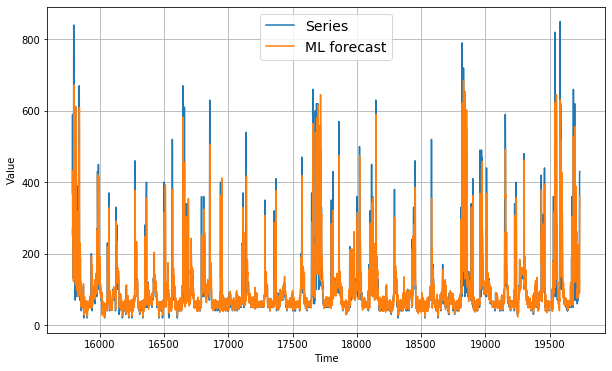

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, dense_forecast2, label="ML forecast")

In [30]:
tf.keras.metrics.mse(x_valid, dense_forecast2).numpy()

3631.3997

In [31]:
tf.keras.metrics.mae(x_valid, dense_forecast2).numpy()

27.956148

* Adam, apparently performed better